In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from scipy.spatial.transform import Rotation as R

from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score

# Create Training Dataset

In [2]:
side_length = 0.01
num_points = 300
points_per_face = num_points / 6

def generate_face_points(n, axis, coord):
    points = []
    spacing = np.linspace(-side_length/2, side_length/2, int(np.sqrt(n)))

    for i in spacing:
        for j in spacing:
            if axis == 'x':
                points.append([coord, i, j])
            elif axis == 'y':
                points.append([i, coord, j])
            elif axis == 'z':
                points.append([i, j, coord])         
    return points

def generate_cube():
    cube_points = []
    #two faces parallel to the yz-plane (x = +/- side_length/2)
    cube_points += generate_face_points(points_per_face, 'x', side_length / 2)
    cube_points += generate_face_points(points_per_face, 'x', -side_length / 2)
    #two faces parallel to the xz-plane (y = +/- side_length/2)
    cube_points += generate_face_points(points_per_face, 'y', side_length / 2)
    cube_points += generate_face_points(points_per_face, 'y', -side_length / 2)
    #two faces parallel to the xy-plane (z = +/- side_length/2)
    cube_points += generate_face_points(points_per_face, 'z', side_length / 2)
    cube_points += generate_face_points(points_per_face, 'z', -side_length / 2)

    cube_points = np.array(cube_points)
    cube_points = np.unique(cube_points, axis=0)
    return cube_points

def rotate_cube(points, phi, theta, psi):
    rotation = R.from_euler('zxy', [phi, theta, psi], degrees=True)
    rotated_points = rotation.apply(points)
    return rotated_points

def S_func_cube(x, x0, eps, d):
    radius = np.linalg.norm(x - x0)
    epsilon = eps * d
    p1 = np.eye(3, 3) * ((radius**2 + 2 * epsilon**2) / (radius**2 + epsilon**2)**(3/2))
    p2 = (1 / (radius**2 + epsilon**2)**(3/2)) * np.outer(x - x0, x - x0)
    return p1 + p2


In [3]:
def MRS_cube(phi, theta, psi):
    points = generate_cube()
    rotated_cube_points = rotate_cube(points, phi, theta, psi)
    N = len(rotated_cube_points)
    
    u_inf = 1
    vec = np.tile([-1, 0, 0], N)
    vel = u_inf * vec 
    v = vel.reshape(-1, 1)
    
    d = side_length / 7 
    eps = 1
    
    M = np.zeros((3*N,3*N))
    for i in range(N):
        for j in range(N):
            for k in range(3):
                for l in range(3):
                    S = S_func_cube(rotated_cube_points[j], rotated_cube_points[i], eps, d)
                    M[3*i+k][3*j+l] = S[k][l]
        
    F = np.linalg.solve(M, v)
    F_matrix = F.reshape(N, 3)
    Fx = np.sum(F_matrix[:, 0])
    Fy = np.sum(F_matrix[:, 1])
    Fz = np.sum(F_matrix[:, 2])
    F_vector = np.array([Fx, Fy, Fz])
    
    
    return rotated_cube_points, F, F_vector

In [4]:
def generate_mrs_data (num_samples):
    data = []
    for i in range(num_samples):
        phi = np.random.randint(0, 180)
        theta = np.random.randint(0, 180)
        psi = np.random.randint(0, 180)
        
        rotated_cube_points, F, F_vector = MRS_cube(phi, theta, psi)
        F_flat = F.flatten()
        
        data.append([phi, theta, psi, F_flat, F_vector])
        
        if (i + 1) % 100 == 0:
            print(f"{i + 1} samples done")
        
    df = pd.DataFrame(data, columns=['phi', 'theta', 'psi', 'F', 'F_vector'])
    df.to_hdf('mrs_dataset.h5', key='df', mode='w')
    
    print("Data collection complete. Dataset saved as 'mrs_dataset.h5'.")
    return df


In [5]:
### Dont run ###

#df = generate_mrs_data(1000)

# Training

In [6]:
def pad_array(arr, target_length):
    return np.pad(arr, (0, target_length - len(arr)), 'constant') if len(arr) < target_length else arr[:target_length]

df = pd.read_hdf('mrs_dataset.h5', key='df')

max_F_length = max(df['F'].apply(lambda x: len(x.flatten())))
max_F_vector_length = max(df['F_vector'].apply(lambda x: len(x)))

df['F_padded'] = df['F'].apply(lambda x: pad_array(x.flatten(), max_F_length))
df['F_vector_padded'] = df['F_vector'].apply(lambda x: pad_array(x, max_F_vector_length))

X = df[['phi', 'theta', 'psi']].values

y = np.hstack([
    np.stack(df['F_padded'].values),
    np.stack(df['F_vector_padded'].values)
])

print(f"X shape: {X.shape}")
print(f"y shape: {y.shape}")

X shape: (1000, 3)
y shape: (1000, 657)


In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print(f"X_train shape: {X_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"y_test shape: {y_test.shape}")

X_train shape: (800, 3)
X_test shape: (200, 3)
y_train shape: (800, 657)
y_test shape: (200, 657)


In [8]:
# use tune hyperparamters
rf_param = RandomForestRegressor()
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

grid_search = GridSearchCV(estimator=rf_param, param_grid=param_grid, cv=2, scoring='neg_mean_squared_error', verbose=2)
grid_search.fit(X_train, y_train)
print(f"Best parameters: {grid_search.best_params_}")

Fitting 2 folds for each of 108 candidates, totalling 216 fits
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   2.5s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   2.4s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   5.0s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   5.1s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=300; total time=   8.1s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=300; total time=   7.7s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=   1.6s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=   1.6s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=5, n_estimators=200; total time=   3.2s
[CV] END m

[CV] END max_depth=10, min_samples_leaf=2, min_samples_split=5, n_estimators=200; total time=   3.0s
[CV] END max_depth=10, min_samples_leaf=2, min_samples_split=5, n_estimators=200; total time=   3.0s
[CV] END max_depth=10, min_samples_leaf=2, min_samples_split=5, n_estimators=300; total time=   4.8s
[CV] END max_depth=10, min_samples_leaf=2, min_samples_split=5, n_estimators=300; total time=   4.9s
[CV] END max_depth=10, min_samples_leaf=2, min_samples_split=10, n_estimators=100; total time=   1.2s
[CV] END max_depth=10, min_samples_leaf=2, min_samples_split=10, n_estimators=100; total time=   1.2s
[CV] END max_depth=10, min_samples_leaf=2, min_samples_split=10, n_estimators=200; total time=   2.4s
[CV] END max_depth=10, min_samples_leaf=2, min_samples_split=10, n_estimators=200; total time=   2.4s
[CV] END max_depth=10, min_samples_leaf=2, min_samples_split=10, n_estimators=300; total time=   3.7s
[CV] END max_depth=10, min_samples_leaf=2, min_samples_split=10, n_estimators=300; tot

[CV] END max_depth=20, min_samples_leaf=4, min_samples_split=10, n_estimators=300; total time=   3.5s
[CV] END max_depth=30, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   2.4s
[CV] END max_depth=30, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   2.4s
[CV] END max_depth=30, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   4.9s
[CV] END max_depth=30, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   4.9s
[CV] END max_depth=30, min_samples_leaf=1, min_samples_split=2, n_estimators=300; total time=   7.7s
[CV] END max_depth=30, min_samples_leaf=1, min_samples_split=2, n_estimators=300; total time=   7.8s
[CV] END max_depth=30, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=   1.5s
[CV] END max_depth=30, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=   1.6s
[CV] END max_depth=30, min_samples_leaf=1, min_samples_split=5, n_estimators=200; total ti

#### max_depth = NONE
Having no limit on the maximum depth means that each tree can continue to grow until it has fully fit the data -> often leads to overfitting because the model becomes very detailed and specific to the training data -> resulting in low training error but high validation error

#### min_samples_leaf = 1
1 also allows for very detailed trees, where each leaf node can have just a single data point -> promotes overfitting since the model tries to capture even the smallest variations in the data

#### min_samples split = 2
default and means that each internal node can split as long as it has at least 2 samples -> makes the trees grow deep, contributing to overfitting



In [18]:
rf = RandomForestRegressor(
    n_estimators=50,        #fewer trees for faster training and less complexity
    max_depth=15,           #restrict the depth to force generalization
    min_samples_split=5,    #increase minimum samples needed to split a node
    min_samples_leaf=3,     #increase the minimum number of samples in each leaf
    random_state=42
)
rf.fit(X_train, y_train)

y_train_pred = rf.predict(X_train)
y_test_pred = rf.predict(X_test)

train_mse = mean_squared_error(y_train, y_train_pred)
test_mse = mean_squared_error(y_test, y_test_pred)

print(f"Training MSE: {train_mse}")
print(f"Testing MSE: {test_mse}")

Training MSE: 7.814153243301257e-12
Testing MSE: 1.8544953173657426e-11


Training size 0.1 done.
Training size 0.2 done.
Training size 0.3 done.
Training size 0.4 done.
Training size 0.5 done.
Training size 0.6 done.
Training size 0.7 done.
Training size 0.8 done.
Training size 0.9 done.
Training size 1.0 done.


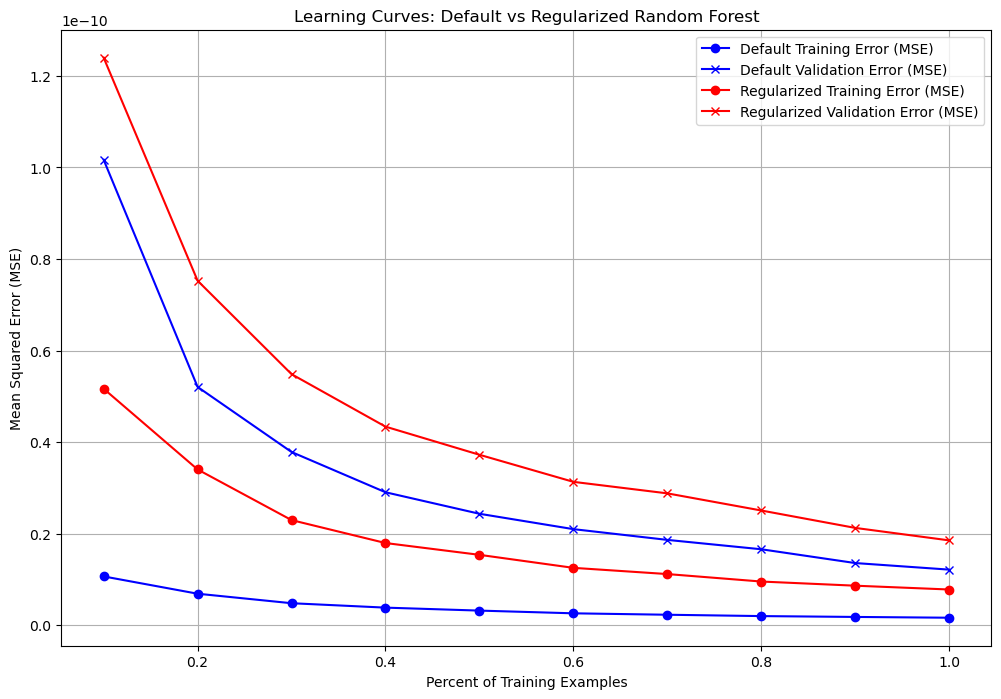

In [19]:
rf_default = RandomForestRegressor(
    n_estimators=100, 
    max_depth=None, 
    min_samples_split=2, 
    min_samples_leaf=1, 
    random_state=42
)

train_sizes = np.linspace(0.1, 1.0, 10)
train_errors_default = []
val_errors_default = []
train_errors_regularized = []
val_errors_regularized = []


for train_size in train_sizes:
    X_train_subset = X_train[:int(train_size * len(X_train))]
    y_train_subset = y_train[:int(train_size * len(y_train))]

    rf_default.fit(X_train_subset, y_train_subset)

    y_train_subset_pred = rf_default.predict(X_train_subset)
    train_mse_default = mean_squared_error(y_train_subset, y_train_subset_pred)
    train_errors_default.append(train_mse_default)

    y_val_pred_default = rf_default.predict(X_test)
    val_mse_default = mean_squared_error(y_test, y_val_pred_default)
    val_errors_default.append(val_mse_default)

    rf.fit(X_train_subset, y_train_subset)

    y_train_subset_pred_reg = rf.predict(X_train_subset)
    train_mse_reg = mean_squared_error(y_train_subset, y_train_subset_pred_reg)
    train_errors_regularized.append(train_mse_reg)

    y_val_pred_reg = rf.predict(X_test)
    val_mse_reg = mean_squared_error(y_test, y_val_pred_reg)
    val_errors_regularized.append(val_mse_reg)

    print(f"Training size {train_size:.1f} done.")

plt.figure(figsize=(12, 8))
plt.plot(train_sizes, train_errors_default, 'o-', color='blue', label='Default Training Error (MSE)')
plt.plot(train_sizes, val_errors_default, 'x-', color='blue', label='Default Validation Error (MSE)')
plt.plot(train_sizes, train_errors_regularized, 'o-', color='red', label='Regularized Training Error (MSE)')
plt.plot(train_sizes, val_errors_regularized, 'x-', color='red', label='Regularized Validation Error (MSE)')
plt.xlabel('Percent of Training Examples')
plt.ylabel('Mean Squared Error (MSE)')
plt.title('Learning Curves: Default vs Regularized Random Forest')
plt.legend()
plt.grid()
plt.show()

### Overfitting:

#### Default
default model overfits the data because the training error is almost zero, but the validation error is relatively high -> large gap between the training and validation errors -> model is memorizing the training data rather than generalizing

#### Regularized
increase in training error indicates that the model is not trying to perfectly fit every detail of the training data -> validation error is closer to the training error in the regularized model -> better balance between fitting the training data and being able to generalize to new data -> reduction in overfitting and an improvement in the model’s ability to generalize

#### Summary
default model is overfitting because it has nearly zero training error but a high validation error, with a large gap between them

regularized model reduces overfitting by increasing the training error while decreasing the validation error, leading to a more balanced performance

##### doesnt seem to have converged/stabilized yet, may need more training data to close the gap

Training size 0.1 done.
Training size 0.2 done.
Training size 0.3 done.
Training size 0.4 done.
Training size 0.5 done.
Training size 0.6 done.
Training size 0.7 done.
Training size 0.8 done.
Training size 0.9 done.
Training size 1.0 done.


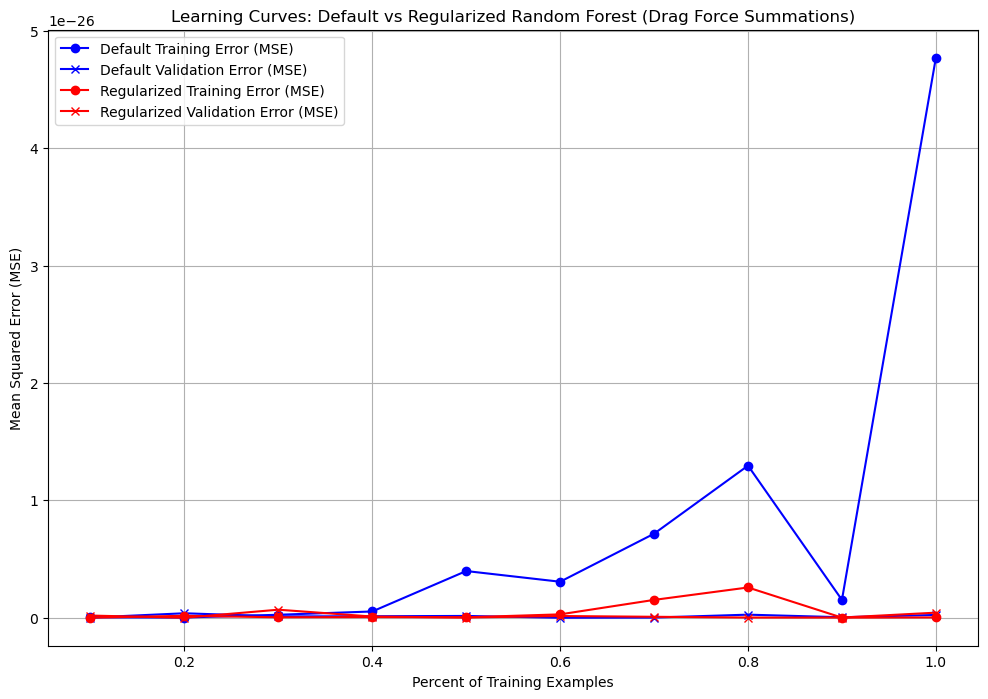

In [21]:
train_sizes = np.linspace(0.1, 1.0, 10)
train_errors_default = []
val_errors_default = []
train_errors_regularized = []
val_errors_regularized = []

for train_size in train_sizes:
    X_train_subset = X_train[:int(train_size * len(X_train))]
    y_train_subset = y_train[:int(train_size * len(y_train))]

    rf_default.fit(X_train_subset, y_train_subset)

    y_train_subset_pred = rf_default.predict(X_train_subset)
    F = np.sum(y_train_subset[:-3].reshape(-1, 3), axis = 0)
    F_pred = np.sum(y_train_subset_pred[:-3].reshape(-1, 3), axis = 0)
    
    train_mse_default = mean_squared_error(F, F_pred)
    train_errors_default.append(train_mse_default)

    y_val_pred_default = rf_default.predict(X_test)
    F_val_pred = np.sum(y_val_pred_default[:-3].reshape(-1, 3), axis = 0)
    F_val_actual = np.sum(y_test[:-3].reshape(-1, 3), axis = 0)
    
    val_mse_default = mean_squared_error(F_val_pred, F_val_actual)
    val_errors_default.append(val_mse_default)

    
    rf.fit(X_train_subset, y_train_subset)

    y_train_subset_pred_reg = rf.predict(X_train_subset)
    F = np.sum(y_train_subset[:-3].reshape(-1, 3), axis = 0)
    F_pred = np.sum(y_train_subset_pred_reg[:-3].reshape(-1, 3), axis = 0)
    
    train_mse_reg = mean_squared_error(F, F_pred)
    train_errors_regularized.append(train_mse_reg)

    y_val_pred_reg = rf.predict(X_test)
    F_val_pred = np.sum(y_val_pred_reg[:-3].reshape(-1, 3), axis = 0)
    F_val_actual = np.sum(y_test[:-3].reshape(-1, 3), axis = 0)
    
    val_mse_reg = mean_squared_error(F_val_pred, F_val_actual)
    val_errors_regularized.append(val_mse_reg)

    print(f"Training size {train_size:.1f} done.")

plt.figure(figsize=(12, 8))
plt.plot(train_sizes, train_errors_default, 'o-', color='blue', label='Default Training Error (MSE)')
plt.plot(train_sizes, val_errors_default, 'x-', color='blue', label='Default Validation Error (MSE)')
plt.plot(train_sizes, train_errors_regularized, 'o-', color='red', label='Regularized Training Error (MSE)')
plt.plot(train_sizes, val_errors_regularized, 'x-', color='red', label='Regularized Validation Error (MSE)')
plt.xlabel('Percent of Training Examples')
plt.ylabel('Mean Squared Error (MSE)')
plt.title('Learning Curves: Default vs Regularized Random Forest (Drag Force Summations)')
plt.legend()
plt.grid()
plt.show()

#### Instability in Default Model
default random forest (blue) appears to be more sensitive to training size, leading to unstable errors -> benefit from hyperparameter tuning

#### Regularized Model Generalization
regularized random forest (red) generalizes better and is more robust across training sizes -> likely due to the regularization applied

#### Potential Overfitting in Default Model
large spikes in the default model suggest it might be overfitting to small training subsets

#### Investigate why the MSE is so small
introduce noise to test the models further -> noise to your dataset can help simulate more realistic data and test the robustness of your model

Training size 0.1 done.
Training size 0.2 done.
Training size 0.3 done.
Training size 0.4 done.
Training size 0.5 done.
Training size 0.6 done.
Training size 0.7 done.
Training size 0.8 done.
Training size 0.9 done.
Training size 1.0 done.


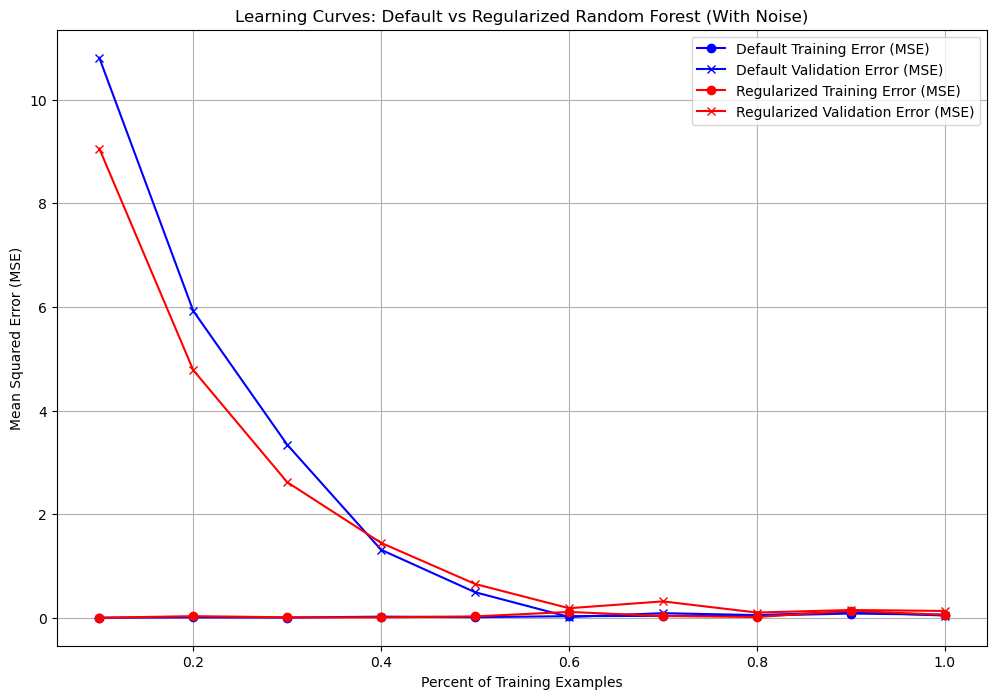

In [27]:
def add_gaussian_noise(data, mean=0, std_dev=0.1):
    return data + np.random.normal(mean, std_dev, data.shape)

train_sizes = np.linspace(0.1, 1.0, 10)
train_errors_default = []
val_errors_default = []
train_errors_regularized = []
val_errors_regularized = []

noise_std_features = 0.01  #standard deviation for feature noise
noise_std_target = 0.005  #standard deviation for target noise

X_train_noisy = add_gaussian_noise(X_train, mean=0, std_dev=noise_std_features)
y_train_noisy = add_gaussian_noise(y_train, mean=0, std_dev=noise_std_target)

for train_size in train_sizes:
    X_train_subset = X_train_noisy[:int(train_size * len(X_train_noisy))]
    y_train_subset = y_train_noisy[:int(train_size * len(y_train_noisy))]

    #default random forest
    rf_default.fit(X_train_subset, y_train_subset)

    y_train_subset_pred = rf_default.predict(X_train_subset)
    F_train_actual = np.sum(y_train_subset[:-3].reshape(-1, 3), axis=0)
    F_train_predicted = np.sum(y_train_subset_pred[:-3].reshape(-1, 3), axis=0)
    train_mse_default = mean_squared_error(F_train_actual, F_train_predicted)
    train_errors_default.append(train_mse_default)

    y_val_pred_default = rf_default.predict(X_test)
    F_val_actual = np.sum(y_test[:-3].reshape(-1, 3), axis=0)
    F_val_predicted = np.sum(y_val_pred_default[:-3].reshape(-1, 3), axis=0)
    val_mse_default = mean_squared_error(F_val_actual, F_val_predicted)
    val_errors_default.append(val_mse_default)

    #regularized random forest
    rf_regularized.fit(X_train_subset, y_train_subset)

    y_train_subset_pred_reg = rf_regularized.predict(X_train_subset)
    F_train_actual = np.sum(y_train_subset[:-3].reshape(-1, 3), axis=0)
    F_train_predicted = np.sum(y_train_subset_pred_reg[:-3].reshape(-1, 3), axis=0)
    train_mse_reg = mean_squared_error(F_train_actual, F_train_predicted)
    train_errors_regularized.append(train_mse_reg)

    y_val_pred_reg = rf_regularized.predict(X_test)
    F_val_actual = np.sum(y_test[:-3].reshape(-1, 3), axis=0)
    F_val_predicted = np.sum(y_val_pred_reg[:-3].reshape(-1, 3), axis=0)
    val_mse_reg = mean_squared_error(F_val_actual, F_val_predicted)
    val_errors_regularized.append(val_mse_reg)

    print(f"Training size {train_size:.1f} done.")

plt.figure(figsize=(12, 8))
plt.plot(train_sizes, train_errors_default, 'o-', color='blue', label='Default Training Error (MSE)')
plt.plot(train_sizes, val_errors_default, 'x-', color='blue', label='Default Validation Error (MSE)')
plt.plot(train_sizes, train_errors_regularized, 'o-', color='red', label='Regularized Training Error (MSE)')
plt.plot(train_sizes, val_errors_regularized, 'x-', color='red', label='Regularized Validation Error (MSE)')
plt.xlabel('Percent of Training Examples')
plt.ylabel('Mean Squared Error (MSE)')
plt.title('Learning Curves: Default vs Regularized Random Forest (With Noise)')
plt.legend()
plt.grid()
plt.show()

#### Default 
Initially performs well on small datasets but suffers from instability and overfitting as training size grows

Validation error fluctuates more than the regularized model's -> sensitivity to noise

#### Regularized
More robust to noise -> errors stabilizing quickly as training size increases

Better overall generalization -> training and validation errors closely aligned

#### Effect of Noise
addition of noise results in higher initial errors compared to the noiseless scenario

both models achieve low and stable errors, but the regularized model shows slightly lower overall error, especially in the validation set -> reinforces the effectiveness of regularization

In [14]:
scores = cross_val_score(rf, X, y, cv=5, scoring='neg_mean_squared_error')
avg_mse = -np.mean(scores)
print(f"Average Cross-Validation MSE: {avg_mse}")

Average Cross-Validation MSE: 1.8059199477598844e-11


In [15]:
if isinstance(X, np.ndarray):

    X = pd.DataFrame(X, columns=['phi', 'theta', 'psi'])

importances = rf.feature_importances_
feature_names = X.columns
feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

print(feature_importance_df)


  Feature  Importance
0     phi    0.372596
1   theta    0.320520
2     psi    0.306884


The feature importances are relatively balanced -> indicates that the model is relying on all input features to make predictions

# Predictions

In [16]:
#predicted_output = rf.predict()
phi = 30
theta = 45
psi = 60

input_data = pd.DataFrame([[phi, theta, psi]], columns=['phi', 'theta', 'psi'])

y_pred = rf.predict(input_data)
print(y_pred.shape)

F_pred = y_pred[:, :-3].reshape(-1, 1)
F_vector_pred = y_pred[:, -3:].flatten()
print(F_pred.shape)
print(F_vector_pred.shape)

points = generate_cube()
rotated_cube_points = rotate_cube(points, phi, theta, psi)
print(rotated_cube_points.shape)

(1, 657)
(654, 1)
(3,)
(218, 3)


C:\Users\User\anaconda3\Lib\site-packages\sklearn\base.py:457: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(


In [17]:
N = len(rotated_cube_points)
L = 1 # Length (meters)
W = 1 # Width (meters)
H = 1 # Height (meters)
u_inf = 1
vec = np.tile([-1, 0, 0], N)
vel = u_inf * vec 
v = vel.reshape(-1, 1)
d = side_length / 7 
eps = 1

Nx = 20
Ny = 20
Nz = 1
Ngrid = Nx*Ny*Nz

r_cube = side_length / 2  #half side length as a scale
x0, x1 = -3 * r_cube, 3 * r_cube
y0, y1 = -3 * r_cube, 3 * r_cube
z0, z1 = 0, 1
dx, dy, dz = (x1 - x0) / (Nx - 1), (y1 - y0) / (Ny - 1), (z1 - z0) #/ (Nz - 1)

fv_points = []
for x in range(Nx):
    for y in range(Ny):
        for z in range(Nz):
            x_coord = x0 + x * dx
            y_coord = y0 + y * dy
            z_coord = z0 + z * dz
            fv_points.append([x_coord, y_coord, z_coord])
FV_points = np.array(fv_points)

M1 = np.zeros((3 * Ngrid, 3 * N)) 
for i in range(Ngrid):
    for j in range(N):
        for k in range(3):
            for l in range(3):
                S = S_func_cube(rotated_cube_points[j], FV_points[i], eps, d)
                M1[3*i+k][3*j+l] = S[k][l]

FV_vel = M1 @ F_pred
FV_vel_matrix = np.reshape(FV_vel, (-1, 3))

tolerance = 0.00075  #control cross-sectional thickness
cross_section_points = rotated_cube_points[np.abs(rotated_cube_points[:, 2]) < tolerance]
x_coords_cs = cross_section_points[:, 0]
y_coords_cs = cross_section_points[:, 1]


x_coords, y_coords, u, v = [], [], [], []
k = 0
for x in range(Nx):
    for y in range(Ny):
        for z in range(Nz):
            x_coord = x0 + x * dx
            y_coord = y0 + y * dy
            z_coord = z0 + z * dz
            radius = np.sqrt(x_coord ** 2 + y_coord ** 2)
    
            if radius > r_cube and abs(z_coord) < 0.5 * dz:
                x_coords.append(x_coord)
                y_coords.append(y_coord)
                u.append(FV_vel[3 * k + 0] + u_inf)
                v.append(FV_vel[3 * k + 1])
            k += 1

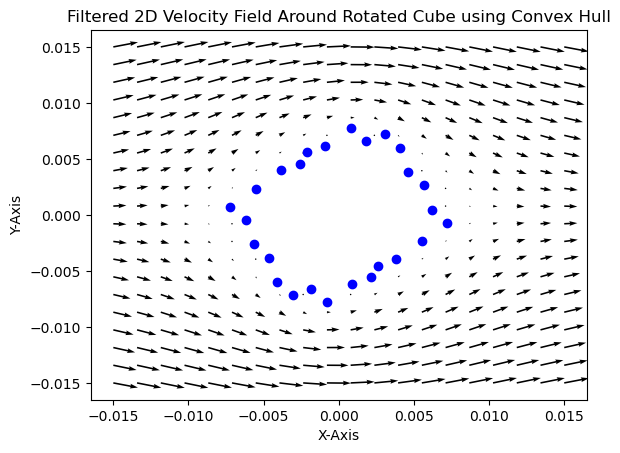

In [18]:
from scipy.spatial import ConvexHull, Delaunay

hull = ConvexHull(rotated_cube_points)
hull_delaunay = Delaunay(rotated_cube_points)

filtered_x_coords = []
filtered_y_coords = []
filtered_u = []
filtered_v = []

k = 0
for i in range(len(x_coords)):
    point = np.array([x_coords[i], y_coords[i], 0])

    if not hull_delaunay.find_simplex(point) >= 0:
        filtered_x_coords.append(x_coords[i])
        filtered_y_coords.append(y_coords[i])
        filtered_u.append(u[i])
        filtered_v.append(v[i])

fig, ax = plt.subplots()
ax.quiver(filtered_x_coords, filtered_y_coords, filtered_u, filtered_v)
ax.scatter(x_coords_cs, y_coords_cs, color='b', marker='o')

ax.set_xlabel('X-Axis')
ax.set_ylabel('Y-Axis')
ax.set_title('Filtered 2D Velocity Field Around Rotated Cube using Convex Hull')
plt.show()

# Prediciting function

In [19]:
def predict (phi, theta, psi, y_pred):
    F_pred = y_pred[:, :-3].reshape(-1, 1)
    F_vector_pred = y_pred[:, -3:].flatten()
    points = generate_cube()
    rotated_cube_points = rotate_cube(points, phi, theta, psi)
    N = len(rotated_cube_points)
    L = 1 # Length (meters)
    W = 1 # Width (meters)
    H = 1 # Height (meters)
    u_inf = 1
    vec = np.tile([-1, 0, 0], N)
    vel = u_inf * vec 
    v = vel.reshape(-1, 1)
    d = side_length / 7 
    eps = 1
    Nx = 20; Ny = 20; Nz = 1
    Ngrid = Nx*Ny*Nz
    r_cube = side_length / 2  #half side length as a scale
    x0, x1 = -3 * r_cube, 3 * r_cube
    y0, y1 = -3 * r_cube, 3 * r_cube
    z0, z1 = 0, 1
    dx, dy, dz = (x1 - x0) / (Nx - 1), (y1 - y0) / (Ny - 1), (z1 - z0) #/ (Nz - 1)
    fv_points = []
    for x in range(Nx):
        for y in range(Ny):
            for z in range(Nz):
                x_coord = x0 + x * dx
                y_coord = y0 + y * dy
                z_coord = z0 + z * dz
                fv_points.append([x_coord, y_coord, z_coord])
    FV_points = np.array(fv_points)
    M1 = np.zeros((3 * Ngrid, 3 * N)) 
    for i in range(Ngrid):
        for j in range(N):
            for k in range(3):
                for l in range(3):
                    S = S_func_cube(rotated_cube_points[j], FV_points[i], eps, d)
                    M1[3*i+k][3*j+l] = S[k][l]
    FV_vel = M1 @ F_pred
    FV_vel_matrix = np.reshape(FV_vel, (-1, 3))
    tolerance = 0.00075
    cross_section_points = rotated_cube_points[np.abs(rotated_cube_points[:, 2]) < tolerance]
    x_coords_cs = cross_section_points[:, 0]
    y_coords_cs = cross_section_points[:, 1]
    x_coords, y_coords, u, v = [], [], [], []
    k = 0
    for x in range(Nx):
        for y in range(Ny):
            for z in range(Nz):
                x_coord = x0 + x * dx
                y_coord = y0 + y * dy
                z_coord = z0 + z * dz
                radius = np.sqrt(x_coord ** 2 + y_coord ** 2)
    
                if radius > r_cube and abs(z_coord) < 0.5 * dz:
                    x_coords.append(x_coord)
                    y_coords.append(y_coord)
                    u.append(FV_vel[3 * k + 0] + u_inf)
                    v.append(FV_vel[3 * k + 1])
                k += 1
    hull = ConvexHull(rotated_cube_points)
    hull_delaunay = Delaunay(rotated_cube_points)
    filtered_x_coords = []
    filtered_y_coords = []
    filtered_u = []
    filtered_v = []
    k = 0
    for i in range(len(x_coords)):
        point = np.array([x_coords[i], y_coords[i], 0])
        if not hull_delaunay.find_simplex(point) >= 0:
            filtered_x_coords.append(x_coords[i])
            filtered_y_coords.append(y_coords[i])
            filtered_u.append(u[i])
            filtered_v.append(v[i])
    fig, ax = plt.subplots()
    ax.quiver(filtered_x_coords, filtered_y_coords, filtered_u, filtered_v)
    ax.scatter(x_coords_cs, y_coords_cs, color='b', marker='o')
    ax.set_xlabel('X-Axis')
    ax.set_ylabel('Y-Axis')
    ax.set_title('Filtered 2D Velocity Field Around Rotated Cube using Convex Hull')
    plt.show()

C:\Users\User\anaconda3\Lib\site-packages\sklearn\base.py:457: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(


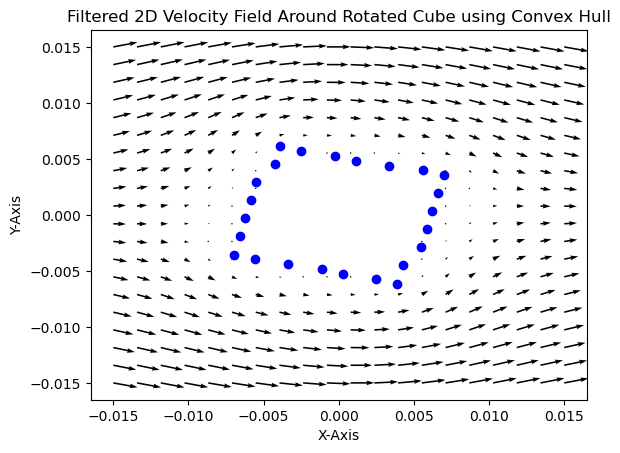

In [21]:
phi = 0
theta = 15
psi = 60

input_data = pd.DataFrame([[phi, theta, psi]], columns=['phi', 'theta', 'psi'])
y_pred = rf.predict(input_data)

predict(phi, theta, psi, y_pred)